In [ ]:
# Confirme Cases Sarima Model.

CONFIRM CASES


In [ ]:
pip install helper

**Importing the important libraries**

In [4]:
%matplotlib inline

import sys
sys.path.append("../")
import copy
import itertools
import operator

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from math import sqrt
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller, acf, pacf
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
import helper
import warnings
warnings.filterwarnings("ignore")


/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [5]:
from google.colab import files
uploaded = files.upload()

Saving covid_19_clean_complete.csv to covid_19_clean_complete (1).csv


**Reading the dataset**

In [7]:
dataframe=pd.read_csv('/content/covid_19_clean_complete.csv', parse_dates=['Date'])
dataframe['Province/State']=dataframe['Province/State'].fillna('')
dataframe.rename(columns={'Country/Region':'Country','Province/State':'State'},inplace=True)
dataframe

State                Country        Lat  ...  Confirmed Deaths  Recovered
0                      Afghanistan  33.000000  ...          0      0          0
1                          Albania  41.153300  ...          0      0          0
2                          Algeria  28.033900  ...          0      0          0
3                          Andorra  42.506300  ...          0      0          0
4                           Angola -11.202700  ...          0      0          0
...     ...                    ...        ...  ...        ...    ...        ...
32060        Sao Tome and Principe   0.186360  ...        251      8          4
32061                        Yemen  15.552727  ...        197     33          0
32062                      Comoros -11.645500  ...         34      1          8
32063                   Tajikistan  38.861034  ...       2350     44          0
32064                      Lesotho -29.609988  ...          1      0          0

[32065 rows x 8 columns]

In [8]:
q=dataframe.query('Country=="Spain"')
df=q.fillna('').groupby(['Date'])['Confirmed'].max()
df=pd.DataFrame(df)
df

Confirmed
Date                 
2020-01-22          0
2020-01-23          0
2020-01-24          0
2020-01-25          0
2020-01-26          0
...               ...
2020-05-17     230698
2020-05-18     231606
2020-05-19     232037
2020-05-20     232555
2020-05-21     233037

[121 rows x 1 columns]

**Spilting the dataset**

In [10]:
train=df[0:97]
test=df[97:]
test

Confirmed
Date                 
2020-04-28     210773
2020-04-29     212917
2020-04-30     213435
2020-05-01     215216
2020-05-02     216582
2020-05-03     217466
2020-05-04     218011
2020-05-05     219329
2020-05-06     220325
2020-05-07     221447
2020-05-08     222857
2020-05-09     223578
2020-05-10     224350
2020-05-11     227436
2020-05-12     228030
2020-05-13     228691
2020-05-14     229540
2020-05-15     230183
2020-05-16     230698
2020-05-17     230698
2020-05-18     231606
2020-05-19     232037
2020-05-20     232555
2020-05-21     233037

In [11]:
# Series to test
column_name = df.columns[0]
print(" %s cases will be used for the analysis" % column_name)

 Confirmed cases will be used for the analysis


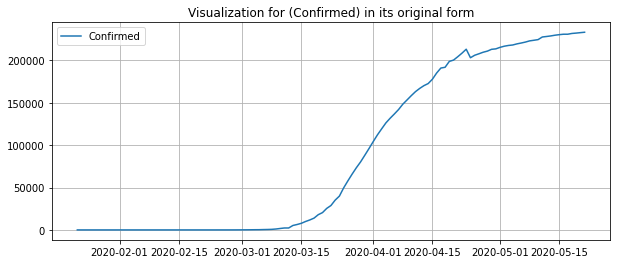

In [12]:
plt.figure(figsize=(10,4))
plt.plot(df, label=column_name)
plt.legend(loc="best")
plt.title("Visualization for (%s) in its original form" %df.columns[0])
plt.grid()
plt.show()

In [13]:
df.tail()

Confirmed
Date                 
2020-05-17     230698
2020-05-18     231606
2020-05-19     232037
2020-05-20     232555
2020-05-21     233037

In [14]:
df_to_test = copy.deepcopy(df)
fill_method = "ffill"
df_to_test[column_name] = df_to_test[column_name].replace(to_replace=0, method=fill_method)
df_to_test = df_to_test.fillna(method=fill_method)

In [15]:
df_to_test.tail()

Confirmed
Date                 
2020-05-17     230698
2020-05-18     231606
2020-05-19     232037
2020-05-20     232555
2020-05-21     233037

In [16]:
def fit_model(series, config):
    order, sorder, trend = config
    model = SARIMAX(series[column_name], order=order, seasonal_order=sorder, trend=trend, enforce_stationarity=False, enforce_invertibility=False)
    result = model.fit()
    return result

In [17]:
# root mean squared error
def measure_rmse(actual, predicted):
    return sqrt(mean_squared_error(actual, predicted))

In [18]:
#Mean absolute percentage error (MAPE)
def mape(actual, predicted): 
    actual, predicted = np.array(actual), np.array(predicted)
    return np.mean(np.abs((actual - predicted) / actual)) * 100

In [20]:
#Generate all possible combinations of hyperparameters
    
def sarima_configs(seasonal=None):
    
    if seasonal is None:
        seasonal = [0]
    models = list()
    # combinations
    p_params = [0, 1, 2]
    d_params = [0, 1]
    q_params = [0, 1, 2]
    t_params = ['n','c','t','ct']
    P_params = [0, 1, 2]
    D_params = [0, 1]
    Q_params = [0, 1, 2]
    m_params = seasonal
    for p in p_params:
        for d in d_params:
            for q in q_params:
                for t in t_params:
                    for P in P_params:
                        for D in D_params:
                            for Q in Q_params:
                                for m in m_params:
                                    cfg = [(p,d,q), (P,D,Q,m), t]
                                    models.append(cfg)
    return models

In [21]:
def grid_search(series):
    results = []
    configs = sarima_configs([365])
    for config in configs:
        try:
            result = fit_model(series, config)
            prediction = result.predict(start=0, end=series.count()[0] - 1)
            error = measure_rmse(series, prediction)
            mae = mean_absolute_error(series, prediction)
            
            result = (config, error, mae)
            results.append(result)
            print(result)
        except:
            continue
    return results

In [22]:
print(column_name)
results = grid_search(df_to_test)

Confirmed
([(0, 0, 0), (0, 0, 0, 365), 'n'], 130490.398646892, 88538.39669421487)
([(0, 0, 0), (0, 1, 0, 365), 'n'], 130490.398646892, 88538.39669421487)
([(0, 0, 0), (0, 0, 0, 365), 'c'], 95519.16525886425, 89555.47394303668)
([(0, 0, 0), (0, 0, 0, 365), 't'], 47860.90227799163, 41783.590233016854)
([(0, 0, 0), (0, 0, 0, 365), 'ct'], 34575.80839784517, 28945.82174477577)
([(0, 0, 1), (0, 0, 0, 365), 'n'], 65272.818296871585, 44374.84552843982)
([(0, 0, 1), (0, 0, 0, 365), 'c'], 121634.21183624431, 87814.28525820911)
([(0, 0, 1), (0, 0, 0, 365), 't'], 86873.53695974548, 78148.92729154725)
([(0, 0, 1), (0, 0, 0, 365), 'ct'], 41971.05519767643, 37353.61154246693)
([(0, 0, 2), (0, 0, 0, 365), 'n'], 35810.225040551195, 24181.43564197913)
([(0, 0, 2), (0, 0, 0, 365), 'c'], 57021.84727256582, 45667.9083303161)
([(0, 0, 2), (0, 0, 0, 365), 't'], 59884.066822748515, 52509.20530220094)
([(0, 0, 2), (0, 0, 0, 365), 'ct'], 366115.66734316904, 248501.1985063926)
([(0, 1, 0), (0, 0, 0, 365), 'n'], 

In [23]:
results.sort(key = operator.itemgetter(1))
best_combination = results[0][0]
best_error = results[0][1]
mae = results[0][2]

print(column_name)
print(best_combination, best_error, mae)

Confirmed
[(2, 0, 1), (0, 0, 0, 365), 'ct'] 1653.368396063448 956.168536029211


In [24]:
result = fit_model(df_to_test, best_combination)
predictions = result.predict(start=97, end=120)

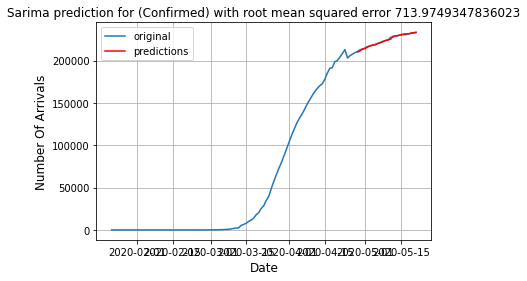

In [25]:
plt.figure(figsize=(6,4))
plt.plot(df_to_test, label="original")
plt.plot(predictions, color="red", label="predictions")
plt.grid()
error = measure_rmse(test, predictions)
#errors=mape(df_to_test,predictions)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Number Of Arrivals', fontsize=12)
plt.legend(loc='best')
plt.title("Sarima prediction for (%s) with root mean squared error %s" % (column_name,error))
#plt.title("Sarima prediction for (%s) with root mean squared error %s" % (column_name,errors))
plt.show()

In [26]:
errors = mape(test, predictions)
errors

3.6385237564656294

In [27]:
#Recovered Cases in Spain'''

RECOVERED CASES

In [28]:
q=dataframe.query('Country=="Spain"')
dfr=q.fillna('').groupby(['Date'])['Recovered'].max()
dfr=pd.DataFrame(dfr)
dfr

Recovered
Date                 
2020-01-22          0
2020-01-23          0
2020-01-24          0
2020-01-25          0
2020-01-26          0
...               ...
2020-05-17     146446
2020-05-18     150376
2020-05-19     150376
2020-05-20     150376
2020-05-21     150376

[121 rows x 1 columns]

**Spilting the dataset**

In [29]:
trainr=dfr[0:97]
testr=dfr[97:]
len(testr)

24

In [30]:
# Series to test
column_name = dfr.columns[0]
print(" %s cases will be used for the analysis" % column_name)

 Recovered cases will be used for the analysis


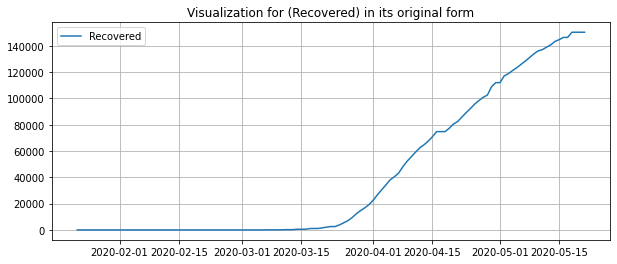

In [31]:
plt.figure(figsize=(10,4))
plt.plot(dfr, label=column_name)
plt.legend(loc="best")
plt.title("Visualization for (%s) in its original form" %dfr.columns[0])
plt.grid()
plt.show()

In [32]:
dfr.tail()

Recovered
Date                 
2020-05-17     146446
2020-05-18     150376
2020-05-19     150376
2020-05-20     150376
2020-05-21     150376

In [33]:
df_to_test = copy.deepcopy(dfr)
fill_method = "ffill"
df_to_test[column_name] = df_to_test[column_name].replace(to_replace=0, method=fill_method)
df_to_test = df_to_test.fillna(method=fill_method)

In [34]:
df_to_test.tail()

Recovered
Date                 
2020-05-17     146446
2020-05-18     150376
2020-05-19     150376
2020-05-20     150376
2020-05-21     150376

In [35]:
def fit_model(series, config):
    order, sorder, trend = config
    model = SARIMAX(series[column_name], order=order, seasonal_order=sorder, trend=trend, enforce_stationarity=False, enforce_invertibility=False)
    result = model.fit()
    return result

In [36]:
# root mean squared error
def measure_rmse(actual, predicted):
    return sqrt(mean_squared_error(actual, predicted))

In [37]:
#Generate all possible combinations of hyperparameters
    
def sarima_configs(seasonal=None):
    
    if seasonal is None:
        seasonal = [0]
    models = list()
    # combinations
    p_params = [0, 1, 2]
    d_params = [0, 1]
    q_params = [0, 1, 2]
    t_params = ['n','c','t','ct']
    P_params = [0, 1, 2]
    D_params = [0, 1]
    Q_params = [0, 1, 2]
    m_params = seasonal
    for p in p_params:
        for d in d_params:
            for q in q_params:
                for t in t_params:
                    for P in P_params:
                        for D in D_params:
                            for Q in Q_params:
                                for m in m_params:
                                    cfg = [(p,d,q), (P,D,Q,m), t]
                                    models.append(cfg)
    return models

In [38]:
def grid_search(series):
    results = []
    configs = sarima_configs([365])
    for config in configs:
        try:
            result = fit_model(series, config)
            prediction = result.predict(start=0, end=series.count()[0] - 1)
            error = measure_rmse(series, prediction)
            mae = mean_absolute_error(series, prediction)
            
            result = (config, error, mae)
            results.append(result)
            print(result)
        except:
            continue
    return results

In [39]:
print(column_name)
results = grid_search(df_to_test)

Recovered
([(0, 0, 0), (0, 0, 0, 365), 'n'], 67541.9407279471, 41474.305785123965)
([(0, 0, 0), (0, 1, 0, 365), 'n'], 67541.9407279471, 41474.305785123965)
([(0, 0, 0), (0, 0, 0, 365), 'c'], 53174.99285722893, 46871.687384741475)
([(0, 0, 0), (0, 0, 0, 365), 't'], 31315.803855242833, 27081.863461708836)
([(0, 0, 0), (0, 0, 0, 365), 'ct'], 23496.60081374789, 20250.272727272728)
([(0, 0, 1), (0, 0, 0, 365), 'n'], 33923.47690664115, 20910.397701267804)
([(0, 0, 1), (0, 0, 0, 365), 'c'], 28459.740332664063, 22829.90826662183)
([(0, 0, 1), (0, 0, 0, 365), 't'], 54805.55412751239, 48254.29614930046)
([(0, 0, 1), (0, 0, 0, 365), 'ct'], 47179.62287703064, 40468.44281654938)
([(0, 0, 2), (0, 0, 0, 365), 'n'], 17863.768908798604, 10957.62891142375)
([(0, 0, 2), (0, 0, 0, 365), 'c'], 32890.76629016062, 21898.387653735324)
([(0, 0, 2), (0, 0, 0, 365), 't'], 36648.172125970836, 32160.193462164112)
([(0, 0, 2), (0, 0, 0, 365), 'ct'], 212538.69228141746, 166504.62088971568)
([(0, 1, 0), (0, 0, 0, 365

In [40]:
results.sort(key = operator.itemgetter(1))
best_combination = results[0][0]
best_error = results[0][1]
mae = results[0][2]

print(column_name)
print(best_combination, best_error, mae)

Recovered
[(2, 0, 2), (0, 0, 0, 365), 't'] 884.4670744277885 537.7705665435859


In [41]:
result = fit_model(df_to_test, best_combination)
predictions = result.predict(start=97, end=120)

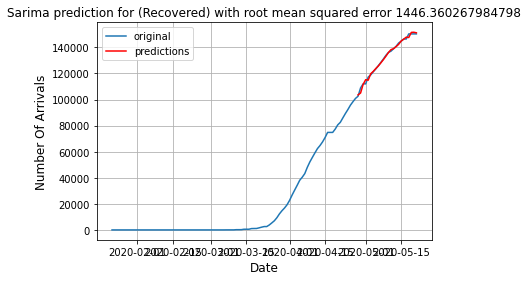

In [42]:
plt.figure(figsize=(6,4))
plt.plot(df_to_test, label="original")
plt.plot(predictions, color="red", label="predictions")
plt.grid()
error = measure_rmse(testr, predictions)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Number Of Arrivals', fontsize=12)
plt.legend(loc='best')
plt.title("Sarima prediction for (%s) with root mean squared error %s" % (column_name, error))
plt.show()

In [43]:
mape(testr, predictions)

13.020848774862406

In [ ]:
# Deaths cases

DEATH CASES

In [44]:
q=dataframe.query('Country=="Spain"')
dfd=q.fillna('').groupby(['Date'])['Deaths'].max()
dfd=pd.DataFrame(dfd)
dfd

Deaths
Date              
2020-01-22       0
2020-01-23       0
2020-01-24       0
2020-01-25       0
2020-01-26       0
...            ...
2020-05-17   27563
2020-05-18   27709
2020-05-19   27778
2020-05-20   27888
2020-05-21   27940

[121 rows x 1 columns]

In [45]:
# Seriies to test
column_name = dfd.columns[0]
print(" %s cases will be used for the analysis" % column_name)

 Deaths cases will be used for the analysis


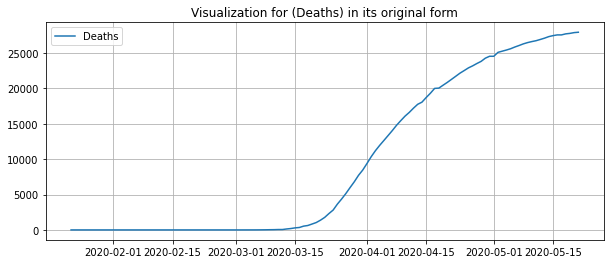

In [46]:
plt.figure(figsize=(10,4))
plt.plot(dfd, label=column_name)
plt.legend(loc="best")
plt.title("Visualization for (%s) in its original form" %dfd.columns[0])
plt.grid()
plt.show()

In [47]:
dfd.tail()

Deaths
Date              
2020-05-17   27563
2020-05-18   27709
2020-05-19   27778
2020-05-20   27888
2020-05-21   27940

**Spilting the dataset**

In [48]:
traind=dfd[0:97]
testd=dfd[97:]
testd

Deaths
Date              
2020-04-28   23822
2020-04-29   24275
2020-04-30   24543
2020-05-01   24543
2020-05-02   25100
2020-05-03   25264
2020-05-04   25428
2020-05-05   25613
2020-05-06   25857
2020-05-07   26070
2020-05-08   26299
2020-05-09   26478
2020-05-10   26621
2020-05-11   26744
2020-05-12   26920
2020-05-13   27104
2020-05-14   27321
2020-05-15   27459
2020-05-16   27563
2020-05-17   27563
2020-05-18   27709
2020-05-19   27778
2020-05-20   27888
2020-05-21   27940

In [49]:
df_to_test = copy.deepcopy(dfd)
fill_method = "ffill"
df_to_test[column_name] = df_to_test[column_name].replace(to_replace=0, method=fill_method)
df_to_test = df_to_test.fillna(method=fill_method)

In [50]:
df_to_test.tail()

Deaths
Date              
2020-05-17   27563
2020-05-18   27709
2020-05-19   27778
2020-05-20   27888
2020-05-21   27940

In [51]:
def fit_model(series, config):
    order, sorder, trend = config
    model = SARIMAX(series[column_name], order=order, seasonal_order=sorder, trend=trend, enforce_stationarity=False, enforce_invertibility=False)
    result = model.fit()
    return result

In [52]:
# root mean squared error
def measure_rmse(actual, predicted):
    return sqrt(mean_squared_error(actual, predicted))

In [53]:
#Generate all possible combinations of hyperparameters
    
def sarima_configs(seasonal=None):
    
    if seasonal is None:
        seasonal = [0]
    models = list()
    # combinations
    p_params = [0, 1, 2]
    d_params = [0, 1]
    q_params = [0, 1, 2]
    t_params = ['n','c','t','ct']
    P_params = [0, 1, 2]
    D_params = [0, 1]
    Q_params = [0, 1, 2]
    m_params = seasonal
    for p in p_params:
        for d in d_params:
            for q in q_params:
                for t in t_params:
                    for P in P_params:
                        for D in D_params:
                            for Q in Q_params:
                                for m in m_params:
                                    cfg = [(p,d,q), (P,D,Q,m), t]
                                    models.append(cfg)
    return models

In [54]:
def grid_search(series):
    results = []
    configs = sarima_configs([365])
    for config in configs:
        try:
            result = fit_model(series, config)
            prediction = result.predict(start=0, end=series.count()[0] - 1)
            error = measure_rmse(series, prediction)
            mae = mean_absolute_error(series, prediction)
            
            result = (config, error, mae)
            results.append(result)
            print(result)
        except:
            continue
    return results

In [55]:
print(column_name)
results = grid_search(df_to_test)

Deaths
([(0, 0, 0), (0, 0, 0, 365), 'n'], 14605.296641123268, 9603.314049586777)
([(0, 0, 0), (0, 1, 0, 365), 'n'], 14605.296641123268, 9603.314049586777)
([(0, 0, 0), (0, 0, 0, 365), 'c'], 10969.45169054344, 10133.349429683765)
([(0, 0, 0), (0, 0, 0, 365), 't'], 5790.543058855778, 5084.779936074555)
([(0, 0, 0), (0, 0, 0, 365), 'ct'], 4176.744045987268, 3544.9783863725206)
([(0, 0, 1), (0, 0, 0, 365), 'n'], 7375.81964757648, 4870.455278092418)
([(0, 0, 1), (0, 0, 0, 365), 'c'], 19952.18568899842, 13634.336065592655)
([(0, 0, 1), (0, 0, 0, 365), 't'], 10056.981119087171, 8877.50040857659)
([(0, 0, 1), (0, 0, 0, 365), 'ct'], 2317.821222648191, 1869.4736935438157)
([(0, 0, 2), (0, 0, 0, 365), 'n'], 3943.451133150404, 2603.936757725813)
([(0, 0, 2), (0, 0, 0, 365), 'c'], 11924.12281503265, 7928.105473092158)
([(0, 0, 2), (0, 0, 0, 365), 't'], 6506.289665930152, 5782.06433519833)
([(0, 0, 2), (0, 0, 0, 365), 'ct'], 3234.610293948276, 2429.455175406131)
([(0, 1, 0), (0, 0, 0, 365), 'n'], 36

In [56]:
results.sort(key = operator.itemgetter(1))
best_combination = results[0][0]
best_error = results[0][1]
mae = results[0][2]

print(column_name)
print(best_combination, best_error, mae)

Deaths
[(2, 1, 2), (0, 0, 0, 365), 't'] 92.66642304127093 51.363037511549706


In [57]:
result = fit_model(df_to_test, best_combination)
predictions = result.predict(start=97, end=120)

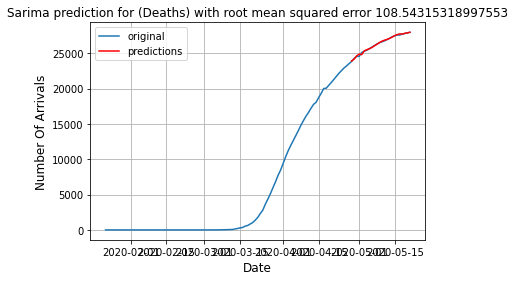

In [58]:
plt.figure(figsize=(6,4))
plt.plot(df_to_test, label="original")
plt.plot(predictions, color="red", label="predictions")
plt.grid()
error = measure_rmse(testd, predictions)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Number Of Arrivals', fontsize=12)
plt.legend(loc='best')
plt.title("Sarima prediction for (%s) with root mean squared error %s" % (column_name, error))
plt.show()

In [59]:
mape(testd,predictions)

5.412516511241621